# The prediction of Kobe Bryant Shot

## Data Source
This project is based on the Kaggle machine learning competition in 2016.

https://www.kaggle.com/c/kobe-bryant-shot-selection


## Data Introduction
The data contains Kobe Bryant’s swishes and misses during his 20-year NBA life. Kobe Bryant marked his retirement from the NBA by scoring 60 points in his final game as a Los Angeles Laker on Wednesday, April 12, 2016. Drafted into the NBA at the age of 17, Kobe earned the sport’s highest accolades throughout his long career. We attempt to forecast whether the basket went in for partial incomplete records. This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Most records are complete while 5000 of them lack the result of a specific basket, which is our aim to predict.

All substantial predictors and their meanings are listed below:

Number|Variable's name|The description of the meaning of the variable  
------|---------------|---------------------------------------------- 
1|action_type|how the player shot a ball(a specific version of `combined_shot_type`)
2|combined_shot_type|how the player shot a ball
3|game_event_id|the id of the game events
4|game_id|the id of the games
5, 6|lat, lon|the position of Kobe when he attempt to shot
7, 8|loc_x, loc_y|the same meaning with `lat` and `lon`
9|minutes_remaining|how many minutes from end of that period
10|period|the number of periods
11|playoffs|`1` represent playoffs and `0` represent regular season
12|season|the season of the game
13|seconds_remaining|means how many seconds from end of that minute
14|shot_distance|the distance between the shot position to the basket
15|shot_made_flag (what we will predict)|whether the basket went in
16|shot_type|whether the attempt is in 2PT Field or 3PT Field
17,18,19|shot_zone_area, shot_zone_basic, shot_zone_range|the position information of the shots
20,21|team_id, team_name|all values are 1610612747 and Los Angeles Lakers because Kobe always played in Lakers
22|game_date|the date of the games
23|matchup, opponent|Kobe's opponent team and whether he belonged to home team or away team
24|shot_id|the id of every shot

## Main Purpose and Evaluation Methods
As stated above, our aim in this project is to predict whether the basket went in or not. So we can first predict the probability of this event for a specific attempt. We will use the data above to get the estimate of all the probability for 5000 incomplete. The evaluation of different results are based on the log loss, which has the following formula:
$$\text{LogLoss}=-\frac{1}{n}\sum_{i=1}^n[y_i\log(\hat{y_i})+(1-y_i)\log(1-\hat{y_i})]$$
where

- $n$ is the number of unknown shot.
- $\hat{y_i}$ is the predicted probability of the event that the basket went in.
- $y_i$ is 1 if the basket went in while it is 0 if the basket did not go in.
- $\log()$ is the natural (base e) logarithm.

**The project mainly includes 4 parts:**
1. Data Preprocessing
2. Exploratory Data Analysis
3. Feature Engineering
4. Model Selection

## Data Preprocessing

In [1]:
### load the libraries
import numpy as np
import pandas as pd 
import plotnine as p9
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, RepeatedStratifiedKFold,GridSearchCV, RepeatedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
import warnings
warnings.filterwarnings("ignore")

In [2]:
### read the data
data_raw = pd.read_csv('data.csv')
data_raw.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. There are 25 columns in this data, and our goal is to predict whether the basket went in, i.e. to predict the value of `shot_made_flag` of some records by using the other 24 variables.

### 1.Check missing values

In [3]:
### check missing value.
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null object
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null int64
team_name         

We can see that all the features have no missing values except `shot_made_flag`. The record with missing `shot_made_flag` is what we want to predict. So, we split the data into two parts(training part and predict part).

In [4]:
### extract prediction data from raw data
data_nomissing =  data_raw.dropna().copy()
data_nomissing.reset_index(inplace= True)
del data_nomissing['index']
data_predict = data_raw[data_raw['shot_made_flag'].isna()].copy()

## Exploratory Data Analysis 

Then, let's figure out what the features mean.

### 1. action_type, combined_shot_type

These two features represents how the player shot a ball. Actually, `action_type` is a specific version of `combined_shot_type`. For example, `Slam Dunk Shot`(`action_type`) is `Dunk`(combined_shot_type).

In [5]:
### see the type of action_type
data_nomissing['action_type'].unique()

array(['Jump Shot', 'Driving Dunk Shot', 'Layup Shot',
       'Running Jump Shot', 'Reverse Dunk Shot', 'Slam Dunk Shot',
       'Driving Layup Shot', 'Turnaround Jump Shot', 'Reverse Layup Shot',
       'Tip Shot', 'Running Hook Shot', 'Alley Oop Dunk Shot',
       'Dunk Shot', 'Alley Oop Layup shot', 'Running Dunk Shot',
       'Driving Finger Roll Shot', 'Running Layup Shot',
       'Finger Roll Shot', 'Fadeaway Jump Shot', 'Follow Up Dunk Shot',
       'Hook Shot', 'Turnaround Hook Shot', 'Jump Hook Shot',
       'Running Finger Roll Shot', 'Jump Bank Shot',
       'Turnaround Finger Roll Shot', 'Hook Bank Shot',
       'Driving Hook Shot', 'Running Tip Shot',
       'Running Reverse Layup Shot', 'Driving Finger Roll Layup Shot',
       'Fadeaway Bank shot', 'Pullup Jump shot', 'Finger Roll Layup Shot',
       'Turnaround Fadeaway shot', 'Driving Reverse Layup Shot',
       'Driving Slam Dunk Shot', 'Step Back Jump shot',
       'Turnaround Bank shot', 'Reverse Slam Dunk Shot',
   

In [6]:
### see the type of combined_shot_type
data_nomissing['combined_shot_type'].unique()

array(['Jump Shot', 'Dunk', 'Layup', 'Tip Shot', 'Hook Shot', 'Bank Shot'],
      dtype=object)

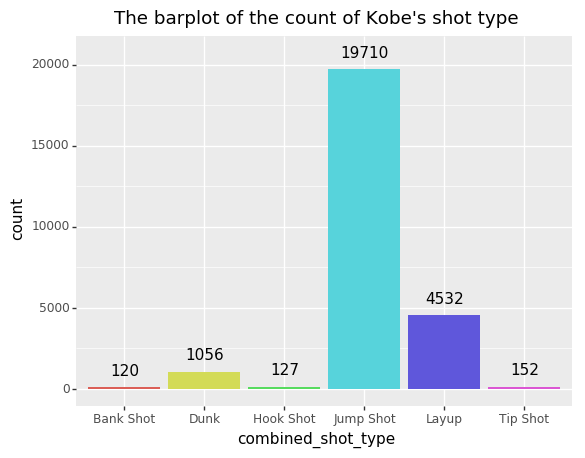

<ggplot: (167190693282)>

In [7]:
### make plot
p9.ggplot(data_nomissing, p9.aes('combined_shot_type'))\
+ p9.geom_bar(p9.aes(fill = 'combined_shot_type'), show_legend = False)\
+ p9.geom_text(p9.aes(label = 'stat(count)'), stat = 'count', nudge_y = 1000) \
+ p9.labels.ggtitle('The barplot of the count of Kobe\'s shot type')

The most common `combined_shot_type` for Kobe is `Jump Shot`. Besides, `Layup` is a common type for Kobe. It's intuitive because Kobe always played as a Shooting Guard(SG) or Small Forward(SF). 

Let's see the accuracy for every `combined_shot_type`.

In [8]:
###see the accuracy for every combined_shot_type.
accu_shot_type = data_nomissing[['combined_shot_type', 'shot_made_flag']].groupby('combined_shot_type').mean()
accu_shot_type.columns = ['accuracy']
accu_shot_type

,accuracy
combined_shot_type,
Bank Shot,0.791667
Dunk,0.928030
Hook Shot,0.535433
Jump Shot,0.391071
Layup,0.565093
Tip Shot,0.348684


The result shows that Kobe had the highest accuracy when the shot type is `Dunk` and had the relatively lowest accuracy when the shot type is `Tip shot`.

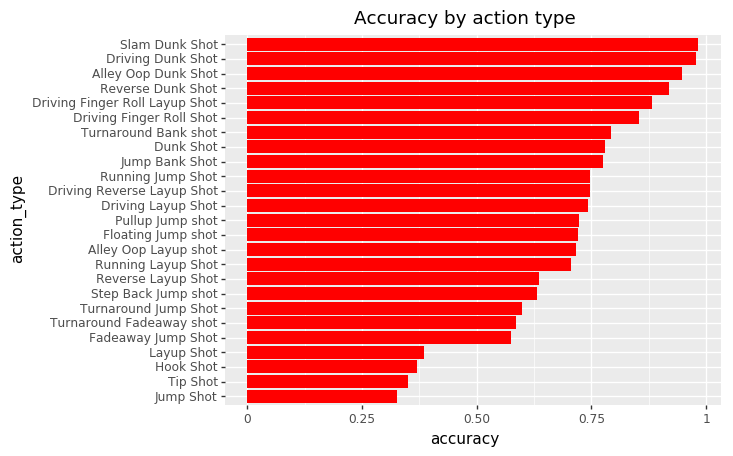

<ggplot: (-9223371869683802073)>

In [9]:
###plot the accuracy of the common action_type.
accu_act_type = data_nomissing[['action_type', 'shot_made_flag']].groupby('action_type').mean()
accu_act_type.columns = ['accuracy']
count_act_type = data_nomissing[['action_type', 'shot_made_flag']].groupby('action_type').count()
count_act_type.columns = ['count']
accu_count_act = accu_act_type.join(count_act_type)
### remove those types whose count is less than 50
accu_50 = accu_count_act[accu_count_act['count']>= 50]
accu_50.reset_index(inplace = True)
accu_50['action_type'] = accu_50['action_type'].astype('category')
accu_50['action_type'] = \
accu_50['action_type'].cat.reorder_categories(accu_50.sort_values('accuracy')['action_type'].tolist(), ordered = True)
p9.ggplot(accu_50, p9.aes(x = 'action_type', y = 'accuracy')) + p9.geom_bar(stat = 'identity', fill = 'r')\
+ p9.coord_flip() + p9.labs(title = 'Accuracy by action type')

Different `action_type` or `combined_shot_type` correspond to totally different accuracy. So, we can conclude that these two features might be  really important to our prediction. So we will consider them as important variables when doing prediction.

### 2. game_event_id, game_id

They represent id of games and game events. They seem to be useless for prediction.

### 3. lat, lon, loc_x, loc_y

The dataset did not give too many descriptions about these features. So we need to figure out what these four features mean. They look like the coordinates, so let's plot them.

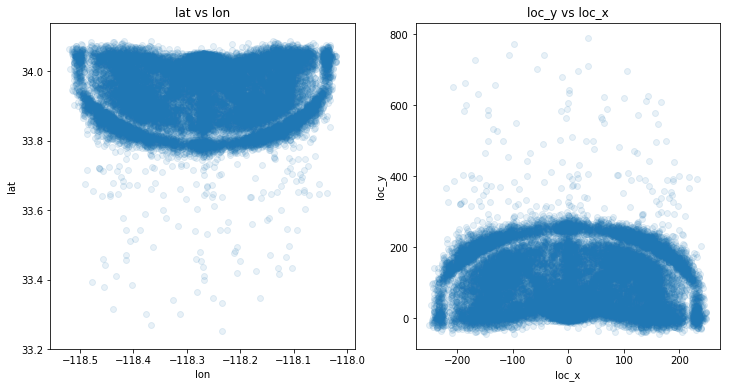

In [10]:
### make plot lat vs lon / loc_y vs loc_x
fig, axes = plt.subplots(1,2, figsize = (12,6))
plot1 = axes[0]
plot2 = axes[1]
plot1.scatter(data_nomissing['lon'], data_nomissing['lat'], alpha= 0.1)
plot1.set_title('lat vs lon')
plot1.set_xlabel('lon')
plot1.set_ylabel('lat')
plot2.scatter(data_nomissing['loc_x'], data_nomissing['loc_y'], alpha = 0.1)
plot2.set_title('loc_y vs loc_x')
plot2.set_xlabel('loc_x')
plot2.set_ylabel('loc_y')
plt.show()

The shape of every plot look like half of  the basketball court. The two shapes seem to be the same except reversing y-axis and it seems that `lat`,`lon` show the same information with `loc_x` and `loc_y`. Let's check the correlation between `lon` and `loc_x` and the correlation between `lat` and `loc_y`.

In [11]:
pearsonr(data_nomissing['loc_x'], data_nomissing['lon'])[0]

1.0

In [12]:
pearsonr(data_nomissing['loc_y'], data_nomissing['lat'])[0]

-1.0

The result proves our guess becuase the correlation coefficient between `loc_x` and `lon` is 1 and the correlation coefficient between `loc_y` and `lat` is -1 which imply that they have an exact linear relationship. As a result , we could use either of two paired features in the further studying.

### 4. minutes_remaining, seconds_remaining, period

- `minutes_remaining` means how many minutes from end of that period.
- `seconds_remaining` means how many seconds from end of that minute.
- `period` means the number of periods. 

The maximum period here is 7. Usually, a basketball match has 4 periods. But when two teams have the same score in the end of a game, there would be overtime(s), so we can see there are at most 3 overtimes among all the records. Additionally, every regular period correspond to 12 minutes and every overtime period correspond to 5 minutes. 

Also, I think it doesn't make sense that I seperately consider `seconds_remaining`. So, we will define a new feature describing time from game starting.

In [13]:
### define a function to calculate time from game starting
def cal_time(period, minute, seconds):
    """calculate shot time(s) from the game starting"""
    if period <= 4:
        time = period* 720 - seconds - minute * 60
    else: 
        time = 2880 + (period - 4) * 300 - seconds - minute * 60
    return(time)

In [14]:
### apply the cal_time function to transform time
data_time = data_nomissing.copy()
time = data_time.apply(lambda x: cal_time(x['period'], x['minutes_remaining'], x['seconds_remaining']), axis =1)
data_time['time(s)'] = time
data_time[['seconds_remaining','minutes_remaining','period','time(s)']].head()

,seconds_remaining,minutes_remaining,period,time(s)
0,22,10,1,98
1,45,7,1,255
2,52,6,1,308
3,19,6,2,1061
4,32,9,3,1588


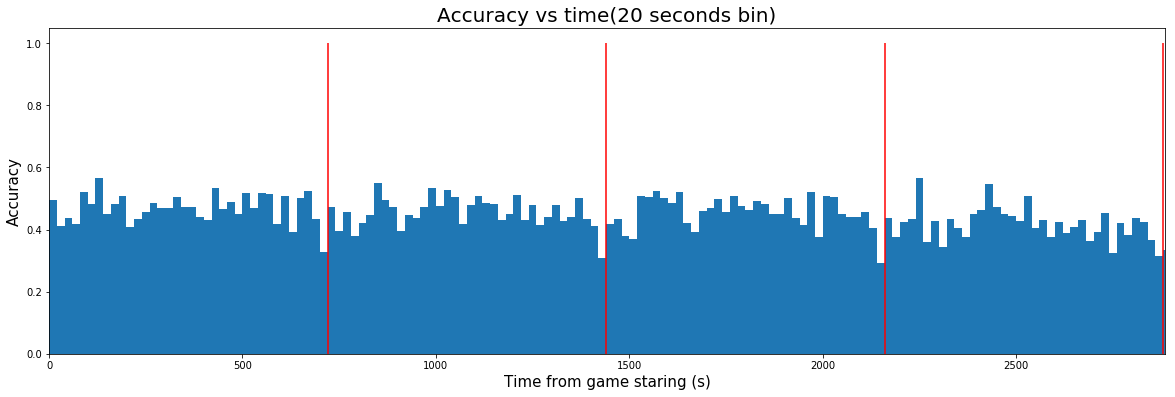

In [15]:
### make accuracy vs time barplot(every bin represent 20 seconds)
### Because the number of data in overtime is small, we don't show the accuracy in overtime.
plot_acc = data_time[['time(s)','shot_made_flag']].copy()
plot_acc['time_group'] = plot_acc['time(s)'].apply(lambda x : ((x-0.1)//20))
resu_acc = plot_acc[['time_group','shot_made_flag']].groupby('time_group').mean()
plt.figure(figsize=(20,6))
plt.bar(resu_acc.index*20,resu_acc['shot_made_flag'], width= 20, align= 'edge')
plt.vlines([720, 1440, 2160 ,2880] ,0,1,color = 'r' )
plt.xlim(0,2885)
plt.xlabel('Time from game staring (s)', size = 15)
plt.ylabel('Accuracy', size = 15)
plt.title('Accuracy vs time(20 seconds bin)', size = 20)
plt.show()

Every bar represent the accuracy in every group of 20 seconds. The red line represents end of period. We can see a pattern that the accuracy becomes low in the end of period. It might be due to opponents' tough defense, Kobe's nervousness under pressure as well as long shot distance at the end of period.

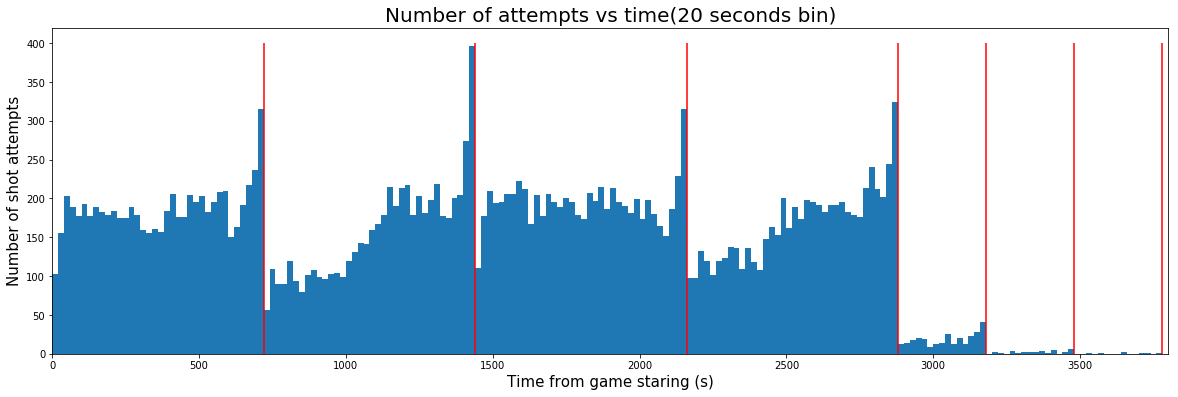

In [16]:
### make plot shot attempts vs time
resu_att = plot_acc[['time_group','shot_made_flag']].groupby('time_group').count()
plt.figure(figsize=(20,6))
plt.bar(resu_att.index*20,resu_att['shot_made_flag'], width= 20, align= 'edge')
plt.vlines([720, 1440, 2160 ,2880, 3180, 3480, 3780] ,0,400,color = 'r' )
plt.xlabel('Time from game staring (s)', size = 15)
plt.ylabel('Number of shot attempts', size = 15)
plt.title('Number of attempts vs time(20 seconds bin)', size = 20)
plt.xlim(0,3800)
plt.show()

We can see that Kobe is the key player in his team and last shot in the end of period is always processed by Kobe because the number of shot attempts in the last 20 seconds of period is obviously higher than usual. Besides, Kobe doesn't fail his team's trust. He showed us many wonderful and amazing clutch shot moments, just like the gif below.

![image](https://github.com/ChunhanLi/Kobe-Bryant-Shot-Selection/blob/master/pic/juesha.gif?raw=true)

Then, let's figure out the relationship between period and accuracy. Since the number of data in overtime is small, we don't show the accuracy in overtime.

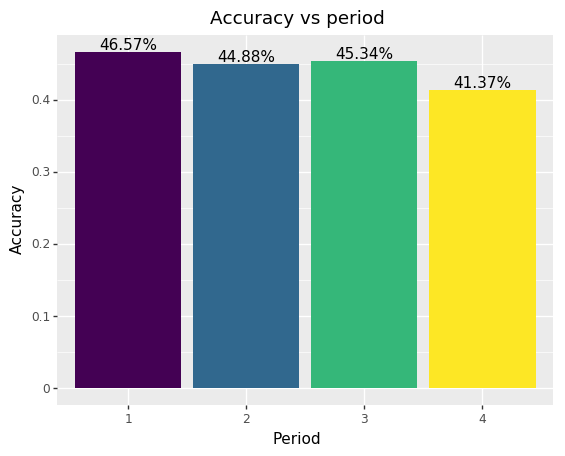

<ggplot: (-9223371869662623302)>

In [17]:
### make accuracy vs period
### Because the number of data in overtime is small, we don't show the accuracy in overtime.
data_period = data_time[data_time['period'] <= 4]
data_period1 = data_period[['period', 'shot_made_flag']].groupby('period').mean()
data_period1.reset_index(inplace = True)
p9.ggplot(data_period1, p9.aes(x = 'factor(period)', y = 'shot_made_flag',fill = 'period'))\
+ p9.geom_bar(stat = 'identity', show_legend = False)\
+ p9.labs(title = 'Accuracy vs period') + p9.xlab('Period') + p9.ylab('Accuracy')\
+ p9.geom_text(p9.aes(label = 'shot_made_flag*100'), format_string = '{:.2f}%', color = 'k', va = 'bottom')

The accuracy in period 4 is a bit lower than that in other 3 periods. It might be due to tougher defense, the decrease of physical strength and huge pressure at the end of the game.

### 5.playoffs

`1` represent playoffs and `0` represent regular season.

Let's see the difference of accuracy between regular season and playoffs.

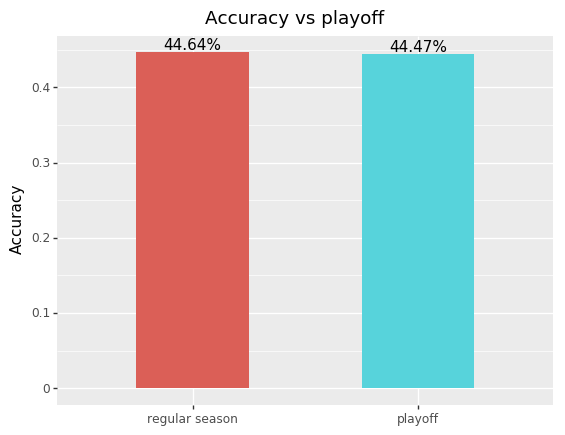

<ggplot: (167192130382)>

In [18]:
### make plot accuracy vs playoff
data_playoffs = data_nomissing[['shot_made_flag', 'playoffs']]
data_playoffs1 = data_playoffs.groupby('playoffs').mean()
data_playoffs1.reset_index(inplace = True)
p9.ggplot(data_playoffs1, p9.aes(x = 'factor(playoffs)', y = 'shot_made_flag', fill = 'factor(playoffs)'))\
+ p9.geom_bar(stat = 'identity', width = 0.5, show_legend = False)\
+ p9.geom_text(p9.aes(label = 'shot_made_flag*100'), format_string = '{:.2f}%', color = 'k', va = 'bottom')\
+ p9.labels.xlab('') + p9.labels.ylab('Accuracy')\
+p9.scale_x_discrete(breaks = [0,1], labels = ['regular season', 'playoff'])\
+ p9.labs(title = 'Accuracy vs playoff ')

We can see that there is not much difference of accuracy between regular season and playoff. So, `playoffs` might not be a good feature for our prediction.

### 6. season

There are totally 20 seasons in Kobe's career. Let's see his accuracy and number of shot attempts among those 20 seasons.

**The number of shot attempt vs season**

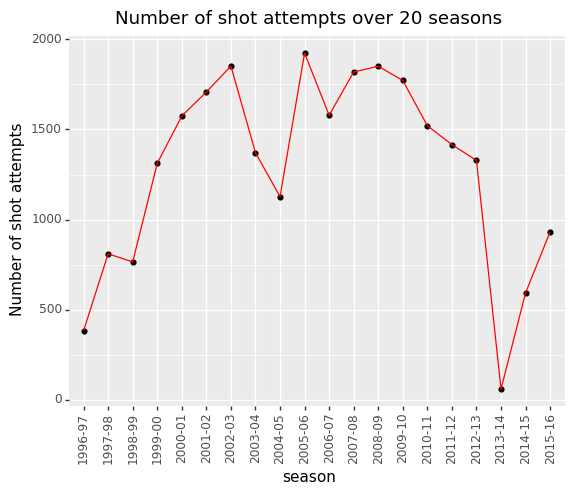

<ggplot: (167192220252)>

In [19]:
## make plot number of shot attempt vs season
data_season = data_nomissing[['season', 'shot_made_flag']].copy()
data_season2 = data_season.groupby('season').count()
data_season2.reset_index(inplace = True)
p9.ggplot(data_season2, p9.aes(x = 'season', y = 'shot_made_flag'))\
+ p9.geom_point() + p9.geom_line(color = 'r', group = 1)\
+ p9.theme(axis_text_x = p9.themes.element_text(rotation=90))\
+ p9.ylab('Number of shot attempts') + p9.labels.ggtitle('Number of shot attempts over 20 seasons')

From the figure above, we can find that the totally trend of the shot attempts of Kobe first increase then decrease. But there are some small flucturations among them. Specifically, these trends are coorresponding to the event in Kobe's career. For example:
- The shot attempts decreased in `1998-99` rather than increased at Kobe's early career. In fact, the totally number of match is less in `1998-99`, Kobe's shot attempts per match indeed increased and he became the starters.
- The shot attempts decreased in `2003-04` and `2004-05`. O'Neal departure at this time but Kobe's attempts didn't increase.There might be two reasons. Kobe was intensively affected by negative news like not getting along well with new teammate Marlon and also his reputation was getting worse and worse because of being accused of sexual assault.
- Kobe was awarded the regular season's Most Valuable Player Award (MVP) in `2007-08`, and his shot attempt is relatively high in that season.
- The lowest attempts is in `2013-14`, as Kobe suffered a lateral tibial plateau fracture in his left knee and he couldn't play basketball for the whole remaining season.
- Los Angeles Lakers Basketball Team won five championships in `1999-00`, `2000-01`, `2001-02`, `2008-09` and `2009-10`, and Kobe's attempts are all relatively high in these seasons, so we can see he plays an essential role in his team.

**Accuracy vs season**

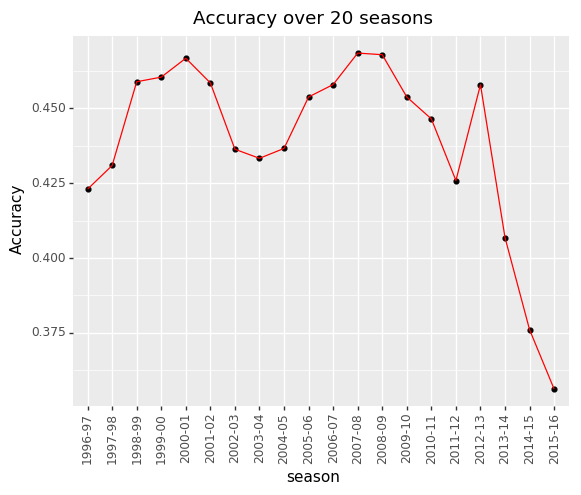

<ggplot: (167190718279)>

In [23]:
### make plot accuracy vs season
data_season = data_nomissing[['season', 'shot_made_flag']].copy()
data_season1 = data_season.groupby('season').mean()
data_season1.reset_index(inplace = True)
p9.ggplot(data_season1, p9.aes(x = 'season', y = 'shot_made_flag'))\
+ p9.geom_point() + p9.geom_line(color = 'r', group = 1)\
+ p9.theme(axis_text_x = p9.themes.element_text(rotation=90))\
+ p9.ylab('Accuracy') + p9.labels.ggtitle('Accuracy over 20 seasons')

Compared with the last figure, we can see that the totally trend of accuracy is similar with the attempts except at the last two seasons. Consider the reasons, it is easy to conclude that both attempts and accuracy are good index to show Kobe's competitive state and thus they are highly correlated with each other. But at the end, Kobe's physics strengths become weaker, so the accuracy may begin to decrease significantly.

**Gained points vs season by combined shot type**

In [21]:
# Calculate the points that Kobe gained in each shot
data_final=data_nomissing.copy()
gain=np.zeros(data_final.shape[0])
for i in range(data_final.shape[0]):
    if(data_final['shot_type'][i]=='2PT Field Goal'):
        gain[i]=2
    else:
        gain[i]=3
data_points=data_final.copy()
data_points['points']=gain
data_points.eval('gain_point=shot_made_flag*points',inplace=True)
### define a function to select the uncommon combined shot type
def others(x):
    if x in ['Bank Shot', 'Hook Shot', 'Tip Shot']:
        return 'Other'
    else:
        return x
data_points['combined_shot_type'] = data_points['combined_shot_type'].apply(others)
# Get the mean points that Kobe gained for each shot type in each year .
points_main=data_points[['combined_shot_type', 'season','gain_point']].groupby(['combined_shot_type','season']).sum()
point_main=points_main.reset_index()

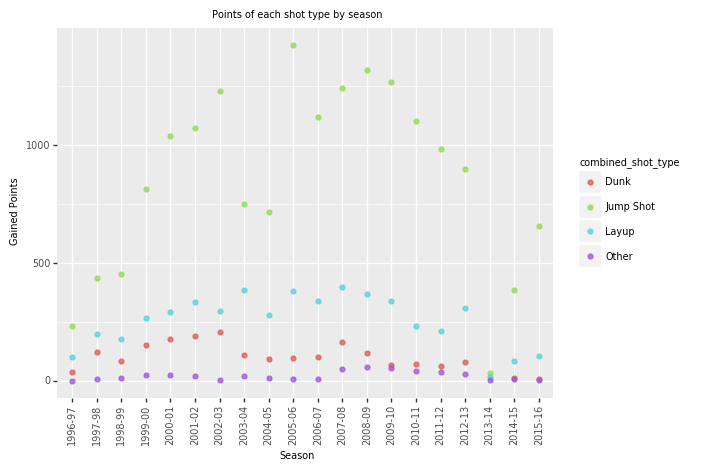

<ggplot: (167191314622)>

In [22]:
### make plots
p9.ggplot(point_main,p9.aes(x='season',y='gain_point',color='combined_shot_type'))+ p9.theme(text=p9.element_text(size=7))\
+ p9.geom_point(alpha=0.8)+ p9.theme(axis_text_x = p9.themes.element_text(rotation=90))\
+ p9.labels.xlab('Season')+ p9.labels.ylab('Gained Points')\
+ p9.labels.ggtitle('Points of each shot type by season' )

The gained points of each shot type by seasons changes roughly corresponding to the change of the number of shot attempt by seasons.

### 7. shot_distance

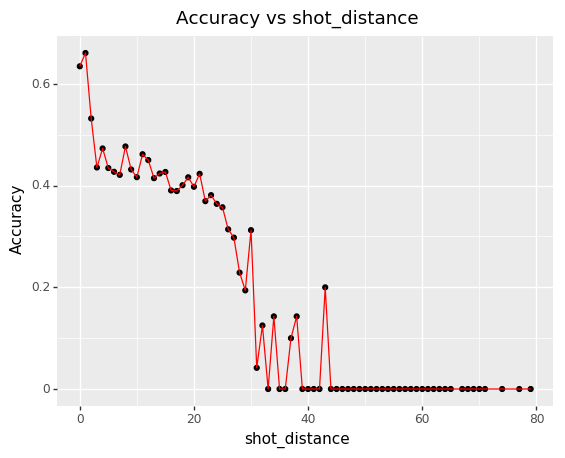

<ggplot: (-9223371869662338742)>

In [24]:
### make plot accuracy vs shot_distance
data_shot = data_nomissing[['shot_distance','shot_made_flag']]
data_shot1 = data_shot.groupby('shot_distance').mean()
data_shot1.reset_index(inplace = True)
p9.ggplot(data_shot1, p9.aes(x = 'shot_distance', y = 'shot_made_flag'))\
+ p9.geom_point() + p9.geom_line(color = 'r', group = 1)\
+ p9.ggtitle('Accuracy vs shot_distance') + p9.labels.ylab('Accuracy')\

we can see the intuitive conclusion that the accuracy decreases as shot distance increases. In the following several parts, we will consider this character in more details.

### 8. shot_type

In [25]:
pd.unique(data_nomissing['shot_type'])

array(['2PT Field Goal', '3PT Field Goal'], dtype=object)

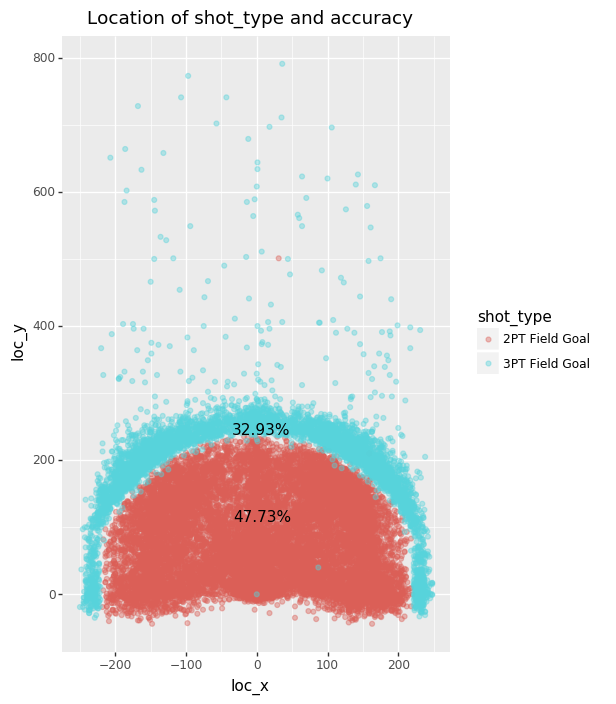

<ggplot: (167191409430)>

In [26]:
### make location of shot_type and accuracy
data_shot_type = data_nomissing[['shot_type','shot_made_flag']].copy()
data_shot_type1 = data_shot_type.groupby('shot_type').mean()
data_shot_type1.reset_index(inplace = True)
posi_shot_type = data_nomissing[['loc_x','loc_y','shot_type']].groupby('shot_type').mean()
posi_shot_type.reset_index(inplace = True)
posi_data = pd.merge(data_shot_type1, posi_shot_type , on = 'shot_type')
p9.ggplot(data_nomissing, p9.aes(x = 'loc_x', y = 'loc_y'))\
+ p9.geom_point(p9.aes( color = 'shot_type'), alpha = 0.4)\
+ p9.theme(figure_size = (5,8))\
+ p9.geom_text(posi_data, p9.aes(x = 'loc_x', y = 'loc_y', label = 'shot_made_flag*100' ), \
               va = 'bottom', nudge_y = 40, format_string = '{:.2f}%')\
+ p9.ggtitle('Location of shot_type and accuracy')

- It is obvious that the accuracy of 2PT Field Goal is higher than it of of 3PT Field Goal.

Also, we can see three obvious outliers in plot (two is near `loc_y` == 0, one is around `loc_y` == 50).

We need to correct them for the sake of following prediction.

In [27]:
### correct obvious outliers
data_raw.loc[(data_raw['loc_y'] > 400) & (data_raw['shot_type'] == '2PT Field Goal'), 'shot_type'] = '3PT Field Goal'
cond = ((data_raw['loc_y'] < 100) & (data_raw['shot_type'] == '3PT Field Goal') & (data_raw['loc_x'] > -100) & (data_raw['loc_x'] < 100))
data_raw.loc[cond, 'shot_type'] = '2PT Field Goal'

### 9. shot_zone_area, shot_zone_basic, shot_zone_range

**shot_zone_area**

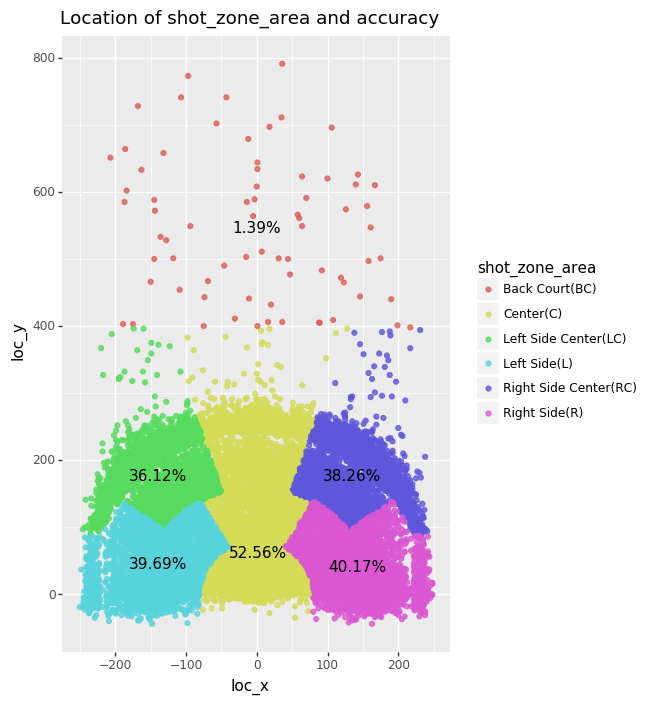

<ggplot: (-9223371869663288004)>

In [28]:
### make plot Location of shot_zone_area and accuracy
data_shot_zone_area = data_nomissing[['shot_zone_area', 'shot_made_flag']].copy()
data_shot_zone_area1 = data_shot_zone_area.groupby('shot_zone_area').mean()
data_shot_zone_area1.reset_index(inplace = True)
posi_zone_area = data_nomissing[['loc_x','loc_y','shot_zone_area']].groupby('shot_zone_area').mean()
posi_zone_area.reset_index(inplace = True)
posi_zone_area1 = pd.merge(data_shot_zone_area1, posi_zone_area, on = 'shot_zone_area')
p9.ggplot(data_nomissing, p9.aes(x = 'loc_x', y = 'loc_y'))\
+ p9.geom_point(p9.aes(color = 'shot_zone_area'), alpha = 0.8)\
+ p9.theme(figure_size = (5,8))\
+ p9.geom_text(posi_zone_area1, p9.aes( x= 'loc_x', y = 'loc_y', label = 'shot_made_flag*100'), format_string = '{:.2f}%')\
+ p9.ggtitle('Location of shot_zone_area and accuracy')

Besides the negative correlation between distance and accuracy, we can see two more interesting conclusion:
- The accuracy at the Right Side is higher than the Left Side, which may be related to the personal habit of Kobe and may be a good predictor that is easy to be ignored.
- The difference between Each side and Each side center is not very huge as in the middle part of the court, which may because extremely partial angles are not easy to thrown into.

**shot_zone_basic**

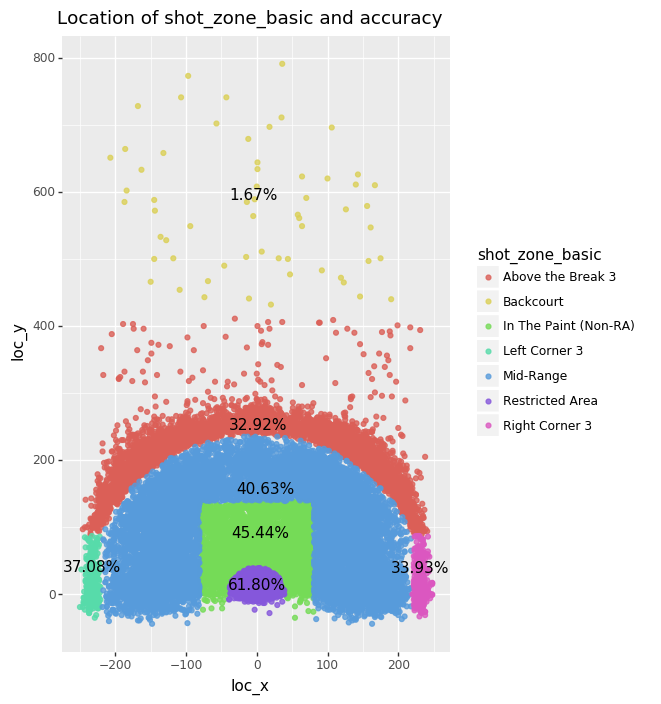

<ggplot: (-9223371869661526121)>

In [29]:
data_shot_zone_basic = data_nomissing[['shot_zone_basic', 'shot_made_flag']].copy()
data_shot_zone_basic1 = data_shot_zone_basic.groupby('shot_zone_basic').mean()
data_shot_zone_basic1.reset_index(inplace = True)
posi_zone_basic = data_nomissing[['loc_x','loc_y','shot_zone_basic']].groupby('shot_zone_basic').mean()
posi_zone_basic.reset_index(inplace = True)
posi_zone_basic1 = pd.merge(data_shot_zone_basic1, posi_zone_basic, on = 'shot_zone_basic')
### adjust the text coorinate
posi_zone_basic1.loc[posi_zone_basic1['shot_zone_basic'] == 'Above the Break 3', 'loc_y'] += 20
posi_zone_basic1.loc[posi_zone_basic1['shot_zone_basic'] == 'Mid-Range', 'loc_y'] += 40
posi_zone_basic1.loc[posi_zone_basic1['shot_zone_basic'] == 'Restricted Area', 'loc_y'] -= 10
### make plot
p9.ggplot(data_nomissing, p9.aes(x = 'loc_x', y = 'loc_y'))\
+ p9.geom_point(p9.aes(color = 'shot_zone_basic'), alpha = 0.8)\
+ p9.theme(figure_size = (5,8))\
+ p9.geom_text(posi_zone_basic1, p9.aes( x= 'loc_x', y = 'loc_y', label = 'shot_made_flag*100'), \
               format_string = '{:.2f}%', nudge_y = 10, va = 'bottom')\
+ p9.ggtitle('Location of shot_zone_basic and accuracy')

- The accuracy at the restricted area is the highest.
- Also, we can see a interesting pattern that the accuracy of left corner 3 is higher than the accuracy of right corner 3.

**shot_zone_range**

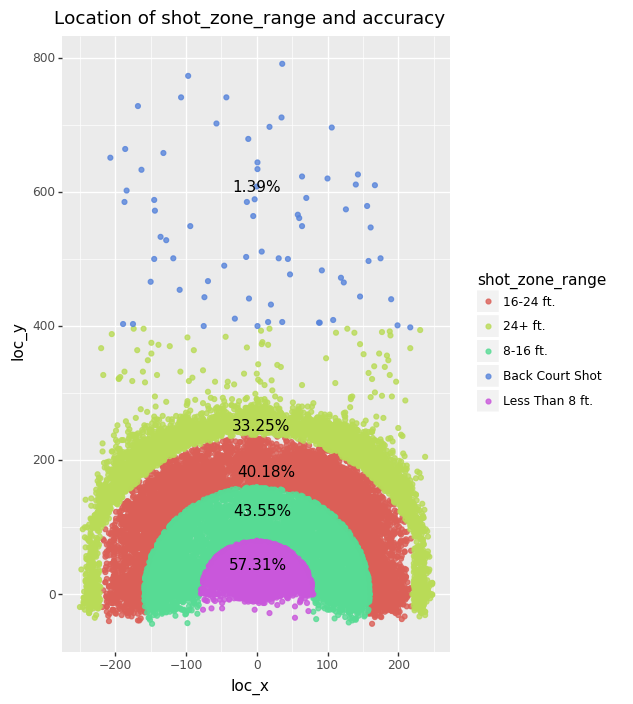

<ggplot: (-9223371869663376068)>

In [30]:
### make plot Location of shot_zone_range and accuracy
data_shot_zone_range = data_nomissing[['shot_zone_range', 'shot_made_flag']].copy()
data_shot_zone_range1 = data_shot_zone_range.groupby('shot_zone_range').mean()
data_shot_zone_range1.reset_index(inplace = True)
posi_zone_range = data_nomissing[['loc_x','loc_y','shot_zone_range']].groupby('shot_zone_range').mean()
posi_zone_range.reset_index(inplace = True)
posi_zone_range1 = pd.merge(data_shot_zone_range1, posi_zone_range, on = 'shot_zone_range')
posi_zone_range1.loc[posi_zone_range1['shot_zone_range'] == 'Less Than 8 ft.', 'loc_y'] -= 30
p9.ggplot(data_nomissing, p9.aes(x = 'loc_x', y = 'loc_y'))\
+ p9.geom_point(p9.aes(color = 'shot_zone_range'), alpha = 0.8)\
+ p9.theme(figure_size = (5,8))\
+ p9.geom_text(posi_zone_range1, p9.aes( x= 'loc_x', y = 'loc_y', label = 'shot_made_flag*100'), format_string = '{:.2f}%',\
              va = 'bottom', nudge_y = 50)\
+ p9.ggtitle('Location of shot_zone_range and accuracy')

The rate of decrease of accuracy as remote distance is very fast near the basket while it become slow far away from the basket.

### 10. team_id, team_name

In his whole career, Kobe only stayed in `Los Angeles Lakers`.

In [31]:
pd.unique(data_nomissing['team_id'])

array([1610612747], dtype=int64)

In [32]:
pd.unique(data_nomissing['team_name'])

array(['Los Angeles Lakers'], dtype=object)

### 11. matchup, opponent

First, let's discuss the the relationship between opponent and accuracy.

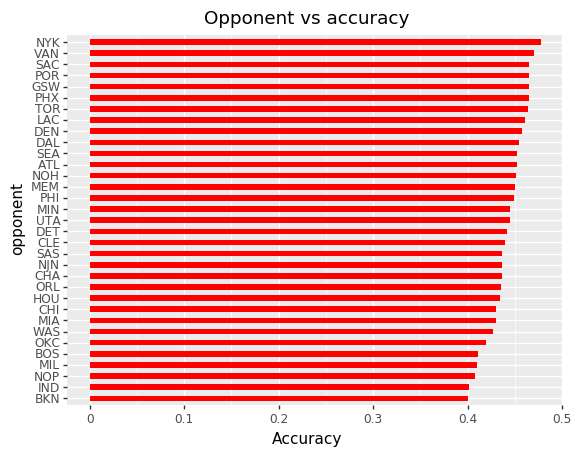

<ggplot: (167198748543)>

In [33]:
### make plot Opponent vs accuracy
data_opponent = data_nomissing[['opponent','shot_made_flag']].copy()
data_opponent1 = data_opponent.groupby('opponent').mean()
data_opponent1.reset_index(inplace = True)
data_opponent2 = data_opponent1.sort_values('shot_made_flag')
ordered_opponent = data_opponent2['opponent'].tolist()
data_opponent2['opponent'] = data_opponent2['opponent'].astype('category')
data_opponent2['opponent'] = data_opponent2['opponent'].cat.reorder_categories(ordered_opponent)
p9.ggplot(data_opponent2, p9.aes(x = 'opponent', y = 'shot_made_flag')) + p9.geom_bar(stat = 'identity', fill = 'r', width = 0.5)\
+ p9.coord_flip() + p9.labels.ylab('Accuracy') + p9.ggtitle('Opponent vs accuracy')

When facing `New York Knicks`, Kobe tend to have the most accuracy. Also, when facing `Brooklyn Nets`, Kobe tend to have the least accuracy.

Second, let's discuss the influence of 'home or away' team.

For example, 'LAL @ POR' means that the match was happened in POR's home and 'LAL vs. POR' means that the match was happened in LAL's home.

In [37]:
#### define a function to get the information about 'home or away'
def home_or_not(str1):
    """
    Determine the 'home or away' situation for every match.
    Return: 1 or 0(1 represent 'home', 0 represent 'away')
    """
    ind = str1.find('vs.')
    if ind != -1:
        return(1)
    else:
        return(0)

In [38]:
data_match = data_nomissing[['matchup', 'shot_made_flag']].copy()
data_match['home'] = data_match['matchup'].apply(home_or_not)
home_away = data_match[['home','shot_made_flag']].groupby('home').mean()
home_away.reset_index(inplace = True)
home_away
home_away['home'] = home_away['home'].astype('category')
home_away['home'] = home_away['home'].cat.reorder_categories([1,0], ordered = True)
home_away

,home,shot_made_flag
0,0,0.436421
1,1,0.456468


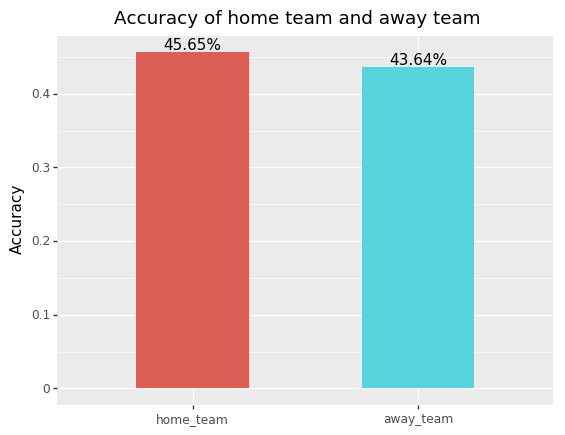

<ggplot: (167192159394)>

In [39]:
### make ggplot
p9.ggplot(home_away, p9.aes(x = 'factor(home)', y = 'shot_made_flag', fill = 'factor(home)'))\
+ p9.geom_bar(stat = 'identity', width = 0.5, show_legend = False)\
+ p9.geom_text(p9.aes(label = 'shot_made_flag*100'), format_string = '{:.2f}%', color = 'k', va = 'bottom')\
+ p9.labels.xlab('') + p9.labels.ylab('Accuracy')\
+ p9.scale_x_discrete(breaks = [1,0], labels = ['home_team', 'away_team'])\
+ p9.labs(title = 'Accuracy of home team and away team')

It make sense that the home accuracy is a bit higher than the away accuracy.

### 12. game_date

Now we can consider the `game_date`, which indicate whether the game is hold at the beginning of the season or the end of the season.

In [40]:
### Let's see the month where NBA season starts and ends.
data_season_period = data_nomissing[['shot_made_flag', 'game_date']].copy()
game_date = data_season_period['game_date']
season_period = []
for i in(range(game_date.shape[0])):
    season_period.append(game_date[i].split('-')[1])
data_season_period['season_period'] = season_period
data_season_period['season_period'].unique()

array(['10', '11', '12', '01', '02', '03', '04', '05', '06'], dtype=object)

The games are hold on nine months, since the NBA seasons all begin in October and end in June of the next year.

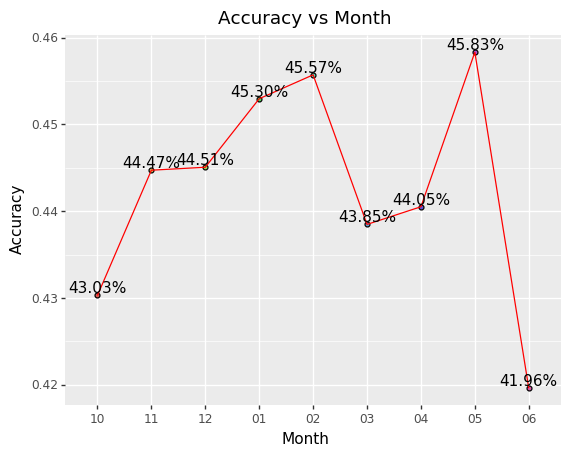

<ggplot: (-9223371869660511719)>

In [41]:
### make accuracy vs season_period
data_season_period1 = data_season_period[['season_period', 'shot_made_flag']].groupby('season_period').mean()
data_season_period1.reset_index(inplace = True)
data_season_period1['season_period'] = data_season_period1['season_period'].astype('category')
data_season_period1['season_period'] =\
data_season_period1['season_period'].cat.reorder_categories(['10','11','12','01','02','03','04','05','06'], ordered = True)
p9.ggplot(data_season_period1, p9.aes(x = 'season_period', y = 'shot_made_flag',fill = 'season_period'))\
+ p9.geom_point(stat = 'identity', show_legend = False)\
+ p9.geom_line(color = 'r', group = 1)\
+ p9.labs(title = 'Accuracy vs Month') + p9.xlab('Month') + p9.ylab('Accuracy')\
+ p9.geom_text(p9.aes(label = 'shot_made_flag*100'), format_string = '{:.2f}%', color = 'k', va = 'bottom')

The result shows that the accuracy is slightly different among nine months. It might be caused by noise because the variation of accuracy vs month is small. If it is not caused by noise, we can interpret as followed:

- At the beginning of the season, the accuracy is relatively low and would increased with season goes. 
- But at the end of the regular season(month 03, 04), his accuracy would decrease a bit.
- Kobe's shot accuracy will be the lowest in the last month(06) of the season which may lead by the intense competition in the last few games bewteen strong teams.

## Feature Engineering

1. Feature Construction
    - Using one-hot encoding to preprocess catrgorical data.
    - Improvement of feature `action_type`
    - Prepare numerical features for feature selection.
2. Feature Selection
    - We would use **sequential forward selection** to find optimal subset of feature based on **logloss** of logistic model.


### 1. Feature construction

#### 1.1 One-hot Encoding

**Categorical feature:** `action_type`, `combined_shot_type`, `period`, `playoffs`, `season`, `shot_type`, `shot_zone_area`, `shot_zone_basic`, `shot_zone_range`, `home`, `opponent`.

In [43]:
### one-hot encoding
data_all = data_raw.copy()
data_all['home'] = data_all['matchup'].apply(home_or_not)##`home_or_not` is function defined in EDA part
### transform our one-hot encoding into dataframe for convenience of our feature selection function
def dummy(feature_name):
    return(pd.get_dummies(data_all[feature_name], prefix=feature_name))
action_type = dummy('action_type')
combined_shot_type = dummy('combined_shot_type')
period = dummy('period')
playoffs = dummy('playoffs')
season = dummy('season')
shot_type = dummy('shot_type')
shot_zone_area = dummy('shot_zone_area')
shot_zone_basic = dummy('shot_zone_basic')
shot_zone_range = dummy('shot_zone_range')
home = dummy('home')
opponent = dummy('opponent')

#### 1.2  Improvement of feature `action_type`

In our further studying, we find that our current feature definition is not good, because:
- There are 2 types of `action_type` which only happen in our prediction dataset and do not exist in our training dataset. They are `Cutting Finger Roll Layup Shot` and `Turnaround Fadeaway Bank Jump Shot`.
- In our one-hot encoding, similar but not same action types are treated as totally different categories. For example, `Driving Dunk Shot` and `Reverse Dunk Shot` are both `Dunk Shot` and they are similar but not the same. However, in our one-hot encoding, they are treated as two different categories.

To avoid these two weaknesses, we need to improve this feature `action_type` by splitting key words. For example, `Turnaround Jump Shot` could be splitted into 2 features `Turnaround`, `Jump` and `Turnaround Fadeaway Shot` could be splitted  into 2 features `Turnaround`, `Fadeaway`.

In [44]:
### unify the action type and revise some words
data_atype = data_all['action_type']
data_atype = data_atype.str.lower()
data_atype = data_atype.str.replace('-','')
data_atype = data_atype.str.replace('follow up','followup')
data_atype = data_atype.str.replace('finger roll', 'fingerroll')
### make feature matrix(dataframe)
count_vec = CountVectorizer(stop_words=['shot'], lowercase= True)
resu = count_vec.fit_transform(data_atype)
action_type = pd.DataFrame(resu.toarray(), columns=count_vec.get_feature_names())
action_type.head()

,alley,back,bank,cutting,driving,dunk,fadeaway,fingerroll,floating,followup,...,layup,oop,pullup,putback,reverse,running,slam,step,tip,turnaround
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 1.3 Prepare numerical features for Sequential Forward Selection

**Numerical feature**: `loc_x`, `loc_y`, `time`, `shot_distance`, `minutes_remaining`, `time_left_period`

Besides those feature shown in EDA, we want to creat a new feature `time_left_period` because in EDA, we find the accuracy is low when it's close to the end of that period.

In [45]:
### extract numerical feature
loc_x = data_all[['loc_x']].copy()
loc_y = data_all[['loc_y']].copy()
shot_distance = data_all[['shot_distance']].copy()
minutes_remaining = data_all[['minutes_remaining']].copy()
### define feature `time` as we did in EDA
data_all['time'] = data_all.apply(lambda x: cal_time(x['period'], x['minutes_remaining'], x['seconds_remaining']), axis =1)
time = data_all[['time']]
### creat a new feature time_left_period
data_all['time_left_period'] = data_all.apply(lambda x: x['minutes_remaining'] * 60 + x['seconds_remaining'], axis = 1)
time_left_period = data_all[['time_left_period']].copy()

### 2. Feature Selection

For feature selection, we would use Forward Selection based on logloss of logistic model.

#### 2.1 Scaling Numerical Features 

Here, we use `sklearn.preprocessing.MinMaxScaler` to scale numerical features.

In [46]:
scaler = MinMaxScaler()
time_scaled = scaler.fit_transform(time)
minutes_remaining_scaled = scaler.fit_transform(minutes_remaining)
shot_distance_scaled = scaler.fit_transform(shot_distance)
loc_y_scaled = scaler.fit_transform(loc_y)
loc_x_scaled = scaler.fit_transform(loc_x)
time_left_period_scaled = scaler.fit_transform(time_left_period)

#### 2.2 Sequential Forward Selection

In [47]:
### For the convenience of Sequential Forward Selection, creat dataframe variable for every features.
time_scaled = pd.DataFrame(time_scaled, columns=['time_scaled'])
minutes_remaining_scaled = pd.DataFrame(minutes_remaining_scaled, columns=['minutes_remaining_scaled'])
loc_y_scaled = pd.DataFrame(loc_y_scaled, columns=['loc_y_scaled'])
shot_distance_scaled = pd.DataFrame(shot_distance_scaled, columns=['shot_distance_scaled'])
loc_x_scaled = pd.DataFrame(loc_x_scaled, columns=['loc_x_scaled'])
time_left_period_scaled = pd.DataFrame(time_left_period_scaled, columns=['time_left_period_scaled'])
### set up a dict containing all potential features
Predictor_all = {'loc_y_scaled':loc_y_scaled, 'shot_distance_scaled':shot_distance_scaled,
                'shot_zone_basic':shot_zone_basic, 'shot_zone_range':shot_zone_range,
                'shot_zone_area':shot_zone_area,'shot_type':shot_type,
                'season':season,'period':period,
                'opponent':opponent,'home':home,
                'time_scaled':time_scaled,'minutes_remaining_scaled':minutes_remaining_scaled,
                'minutes_remaining_scaled':minutes_remaining_scaled, 'loc_x_scaled':loc_x_scaled,
                'time_left_period_scaled':time_left_period_scaled, 'combined_shot_type':combined_shot_type,
                'playoffs':playoffs}

In [48]:
###Define three function to do sequence forward selection
def LR_logloss(df_model,k = 4, n = 5, randomseed = 1204):
    """
    calculate logloss for different combination of features
    Using k-fold to do cross-validation
    -----------------------
    Input:
    df_model:dataframe containing X and y
    k: k-fold(default:4)
    n: The repeated time of k-fold(default:5)
    random_seed: The random seed of k-fold(deault:2018)
    Return:
    The mean of logloss
    """
    ### split known dataset and unknown dataset
    X_all = df_model.dropna()
    del X_all['shot_made_flag']
    Y_all = df_model['shot_made_flag'].dropna()
    logloss = []
    ### define k-fold
    skf = RepeatedStratifiedKFold(n_splits= k, n_repeats= n, random_state=randomseed)
    LR=LogisticRegression()
    for train, test in skf.split(X_all, Y_all):
        LR.fit(X_all.iloc[train],Y_all.iloc[train])
        Y_pred = LR.predict_proba(X_all.iloc[test])
        logloss.append(log_loss(Y_all.iloc[test], Y_pred[:,1]))
    return(np.mean(logloss))


def one_step_selection(current_model, repository_feature):
    """
    Based on current_model, add one more feature from repository_feature
    Find the feature reducing the logloss most
    Input:
    current_model(dataframe): current model(containing current features). 
    repository_feature(dict): repository of potential good feature.
    Return:
    best_feature: if str , it is the selected feature name. if 0, all features which are not in the model now don't reduce logloss
    logloss1: corresponding logloss
    """
    temp_logloss = {}
    for key, value in repository_feature.items():
        df_model = current_model.copy().join(value)
        temp_logloss[key] = LR_logloss(df_model)
    best_feature = min(temp_logloss, key = temp_logloss.get)
    logloss1 = temp_logloss[best_feature]
    if LR_logloss(current_model) < temp_logloss[best_feature]:
        return 0,0
    return best_feature, logloss1

def SFS(start_model, start_repository = Predictor_all):
    """
    sequence forward selection based on logloss to do feature selection
    Input:
    start_model(dataframe): start of feature dataframe
    start_repository(dict): potential features.
    Return: 
    Dataframe of selected features
    """
    features = ['action_type']
    length = len(start_repository)
    for i in range(length):
        temp,number = one_step_selection(start_model, start_repository)
        if  temp != 0:
            start_model = start_model.join(start_repository[temp])
            del start_repository[temp]
            features.append(temp)
            print(temp ,':', number)
        if temp == 0:
            break
    return start_model

In [49]:
#### show the result of sequence forward selection
start_model = action_type.join(data_all['shot_made_flag'])
final_model = SFS(start_model, Predictor_all)

shot_zone_range : 0.6123027771313097
season : 0.6111947016316879
time_scaled : 0.61057022151686
shot_zone_area : 0.610039522242105
shot_zone_basic : 0.609764402748212
time_left_period_scaled : 0.6096244197266523
minutes_remaining_scaled : 0.6094049362574886
home : 0.6093991395411412


From EDA part, We know `action_type` is a good predictor. So in the above processing, we choose model features with only `action_type` as initial model. Then, do sequential forward selection.(add one feature reducing logloss most in every step) In the every line above, it indicates the selected features in every step and corresponding logloss. The result show `action_type`(from initial model),`shot_zone_range`, `season`, `time_scaled`, `shot_zone_area`, `shot_zone_basic`,`time_left_period_scaled`, `minutes_remaining_scaled`, `home` are selected feature.

It is noted that we should do sequential forward selection for each model we use below respectively. However, sequential forward selection would cost lots of time for some models, like KNN,SVM, etc. So, we just use those selected features above to do model selection.

## Model Selection
- Use k-fold to do cross-validation. Selection criterion is `logloss`.
- Use sklearn.model_selection.GridSearchSV to tune hyperparameter.
- Models used：
    - Logistic Regression
    - K Nearest Neighbor
    - Decision Tree
    - Support Vector Machines

#### 1. Logistic model

In [50]:
### Define X and y
mask = final_model['shot_made_flag'].isna()
y = final_model.loc[~mask,'shot_made_flag']
data_temp = final_model.copy()[~mask]
del data_temp['shot_made_flag']
X = data_temp.copy()

In [51]:
### tuning hyperparameter
skf = RepeatedKFold(n_splits= 5, n_repeats= 3, random_state= 1204)
logistic=LogisticRegression()
parameters = {'penalty':['l1','l2'], 'C':[0.01,0.1,0.5,1,5,8,10]}
lr = GridSearchCV(estimator=logistic,param_grid=parameters, cv=skf, scoring='neg_log_loss', n_jobs= -1, return_train_score=False)
%time lr.fit(X,y)
print('Best score:',-round(lr.best_score_,5))
print('Best parameters set:',lr.best_params_)

Wall time: 3min 6s
Best score: 0.60934
Best parameters set: {'C': 5, 'penalty': 'l2'}


For logistic model, best hyperparameter are {'C':5, 'penalty':'l2'}. The best logloss is 0.60934.

#### 2. K Nearest Neighbor

In [52]:
### tuning hyperparameter
skf = RepeatedKFold(n_splits= 4, n_repeats= 2, random_state= 1204)
KNN = KNeighborsClassifier()
parameters = {'n_neighbors': [5,20,40,80,100,150,200,1000],'weights': ['uniform', 'distance']}
knn = GridSearchCV(estimator=KNN,param_grid=parameters, cv=skf, scoring='neg_log_loss', n_jobs= 2, return_train_score=False)
%time knn.fit(X,y)
print('Best score:',-round(knn.best_score_,5))
print('Best parameters set:',knn.best_params_)

Wall time: 14min 35s
Best score: 0.63576
Best parameters set: {'n_neighbors': 80, 'weights': 'uniform'}


For KNN, best hyperparameter are {'n_neighbors':80, 'weights':'uniform'}. The best logloss is 0.63576.

#### 3. Support Vector Machines

We only use `rbf` kernel here.

In [53]:
svc = SVC(kernel='rbf', probability=True)
def class_score(X,y,classifier):
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.25, random_state = 1000)
    classifier.fit(train_X, train_y)
    Y_pred = classifier.predict_proba(test_X)
    temp = log_loss(test_y, Y_pred)
    return temp
%time score_svc = class_score(X, y, svc)
print('Score: ',score_svc)

Wall time: 4min 45s
Score:  0.6185445018123613


For `rbf` SVM, the logloss is 0.61854

#### 4. Decision Tree

In [55]:
skf = RepeatedKFold(n_splits= 4, n_repeats= 2, random_state= 1204)
decisiontree = tree.DecisionTreeClassifier()
parameters = { 'max_features':[15,30,40,45,50,55,60,65],'max_depth':[2,3,4,5,6,7,8],'criterion':['entropy', 'gini']}
dt = GridSearchCV(estimator=decisiontree,param_grid=parameters, cv=skf, scoring='neg_log_loss',n_jobs=2)
%time dt.fit(X,y)
print('Best score:',-round(dt.best_score_,5))
print('Best parameters set:',dt.best_params_)

Wall time: 36.8 s
Best score: 0.62933
Best parameters set: {'criterion': 'gini', 'max_depth': 4, 'max_features': 60}


For decision tree, best hyperparameter are {'criterion': 'gini', 'max_depth': 4, 'max_features': 60}. The best logloss is 0.62933.

**Overall, the logloss of logistic model we chose is the smallest. We will use logistic model with C = 5 and L2 penalty to predict the unknown shot.**

In [56]:
### submit the final result to kaggle
LR=LogisticRegression(penalty='l2', C=5)
LR.fit(X,y)
X_predict = final_model[final_model['shot_made_flag'].isna()]
del X_predict['shot_made_flag']
resu = LR.predict_proba(X_predict)
te = pd.DataFrame({'shot_id':(X_predict.index +1),'shot_made_flag':resu[:,1]})
te.to_csv('Final_result.csv', index=False)

We uploaded the final result to the kaggle.com and got 0.61117 logloss.